# MinMod Knowledge Graph

### live at [https://minmod.isi.edu/](https://minmod.isi.edu/) wrapping a [SPARQL Endpoint](https://minmod.isi.edu/sparql).

MinMod is the mineral data **Knowledge Graph (KG)**, integrating heterogeneous data sources including: grade-tonnage data extracted from **mine reports**, **scholarly articles**, **mine site databases**, and **structured tables** to provide a rich, queryable graph of mineral site information, and **links** to additional knowledge bases such as [GeoKB](https://geokb.wikibase.cloud/).

### data in this knowledge graph adhere to this [schema](https://github.com/DARPA-CRITICALMAAS/schemas/blob/main/ta2/README.md).

## Why KGs?

<img src="demo_imgs/minmod_kg.png" alt="minmod kg" width="250"/>

- KGs
  - graphs are natural way to **encode data**
  - KGs use **semantic concepts & relationships** to create a **Semantic Network**
  - involves **spatial & temporal** information
- RDF
  - framework within the **Semantic Web** stack
  - an extension of WWW, enabling the Web of Data (aka **"Linked Data"**)
  - Linked Open Data & **FAIR** data principles

## Constructing the KG

- Extracted data --> `JSON-LD` readers / `TTL` triples reader
- Predefined data
  - Open set of commodity entities (based on MRDS/GeoKB)
  - Finite set of deposit type entities
  - Ontology following schema to enforce class & property constraints

<img src="demo_imgs/minmod_pipeline.png" alt="minmod kg" width="600"/>

## Interacting with the KG
MinMod KG `SPARQL` Sandbox

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
from collections import Counter
import geopandas as gpd
import contextily as ctx
from shapely import wkt
from shapely.wkt import loads
from shapely.errors import WKTReadingError
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()

/var/folders/bm/87n8t34d431d_cdyv_ntp3jm0000gq/T/ipykernel_45410/4099029292.py:13: DeprecationWarning: WKTReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import WKTReadingError


In [2]:
def safe_wkt_load(wkt_string):
    try:
        return loads(wkt_string)
    except WKTReadingError as e:
        print(f"Error converting WKT: {e}")
        return None

In [3]:
def run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=False):
    # add prefixes
    final_query = '''
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX : <https://minmod.isi.edu/resource/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX gkbi: <https://geokb.wikibase.cloud/entity/>
    PREFIX gkbp: <https://geokb.wikibase.cloud/wiki/Property:>
    PREFIX gkbt: <https://geokb.wikibase.cloud/prop/direct/>
    PREFIX geo: <http://www.opengis.net/ont/geosparql#>
    \n''' + query
    # send query
    response = requests.post(
        url=endpoint,
        data={'query': final_query},
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/sparql-results+json"  # Requesting JSON format
        },
        verify=False  # Set to False to bypass SSL verification as per the '-k' in curl
    )
    #print(response.text)
    try:
        qres = response.json()
        if "results" in qres and "bindings" in qres["results"]:
            df = pd.json_normalize(qres['results']['bindings'])
            if values:
                filtered_columns = df.filter(like='.value').columns
                df = df[filtered_columns]
            return df
    except:
        return None

In [4]:
def run_minmod_query(query, values=False):
    return run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=values)

def run_geokb_query(query, values=False):
    return run_sparql_query(query, endpoint='https://geokb.wikibase.cloud/query/sparql', values=values)

--------------------------------------------------------

In [5]:
pd.set_option('display.max_rows', 20)

### 0. Count total number of triples in KG (sanity test)

In [6]:
query = ''' SELECT (COUNT(?s) as ?count)
            WHERE {
                ?s ?p ?o .
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,2397708


### 1. Deposit Types

In [7]:
query = ''' SELECT ?ci ?cn ?cg ?ce
            WHERE {
                ?ci a :DepositType .
                ?ci rdfs:label ?cn .
                ?ci :deposit_group ?cg .
                ?ci :environment ?ce .
            } '''
run_minmod_query(query, values=True)

,ci.value,cn.value,cg.value,ce.value
0,https://minmod.isi.edu/resource/Q366,Sedimentary manganese,Manganese,Basin chemical
1,https://minmod.isi.edu/resource/Q362,Superior-type banded iron formation,Iron formation,Basin chemical
2,https://minmod.isi.edu/resource/Q400,Iron sulfide polymetallic,Metasomatic iron,Regional metasomatic
3,https://minmod.isi.edu/resource/Q457,Climax-type porphyry molybdenum,Porphyry,Magmatic hydrothermal
4,https://minmod.isi.edu/resource/Q345,Lacustrine evaporite trona,Evaporite,Basin evaporative
...,...,...,...,...
184,https://minmod.isi.edu/resource/Q343,Marine evaporite potash,Evaporite,Basin evaporative
185,https://minmod.isi.edu/resource/Q301,Residual placer tin,Placer,Erosional
186,https://minmod.isi.edu/resource/Q330,Supergene zinc,Supergene,Supergene
187,https://minmod.isi.edu/resource/Q379,Kipushi-type sediment- hosted copper- zinc-lead,Sediment-hosted,Basin hydrothermal


### 2. Mineral Inventories

#### 2.1. **Zinc** Ore values, from all inventories, their grades, & cutoff grades, for inventories with grade >= 12

In [8]:
query = ''' SELECT ?o_inv ?comm_name ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Zinc"@en ] .
                
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
                FILTER (?grade >= 12)
            } '''
run_minmod_query(query, values=True)

""


#### 2.2. **Nickel** Ore values, from all inventories, their grades & cutoff grades

In [9]:
query = ''' SELECT ?o_inv ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Nickel"@en ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.22,0.9,https://minmod.isi.edu/resource/inferred
1,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.22,0.9,https://minmod.isi.edu/resource/inferred
2,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.22,0.9,https://minmod.isi.edu/resource/inferred
3,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.22,0.9,https://minmod.isi.edu/resource/inferred
4,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,0.95,0.9,https://minmod.isi.edu/resource/inferred
...,...,...,...,...,...
1963,https://minmod.isi.edu/resource/httpsw3idorgus...,615000,0.72,0.47,https://minmod.isi.edu/resource/inferred
1964,https://minmod.isi.edu/resource/httpsw3idorgus...,615000,0.72,0.47,https://minmod.isi.edu/resource/inferred
1965,https://minmod.isi.edu/resource/httpsw3idorgus...,615000,0.72,0.47,https://minmod.isi.edu/resource/inferred
1966,https://minmod.isi.edu/resource/httpsw3idorgus...,53000,0.18,0.59,https://minmod.isi.edu/resource/inferred


### 3. Commodities

#### 3.1. all commodities and their `GeoKB` URIs

In [10]:
# query = ''' SELECT ?ci ?cn ?gi
#             WHERE {
#                 ?ci a :Commodity .
#                 ?ci :name ?cn .
#                 ?ci owl:sameAs ?gi .
#             } '''
# example_df = run_minmod_query(query)
# example_df

#### 3.2. get commodity symboles from `GeoKB`

In [11]:
# def get_symbol_via_sparql(geokb_uri):
#     query = '''
#     SELECT ?symb
#     WHERE {
#         <%s> gkbt:P17 ?symb .
#     }''' % (geokb_uri)
#     result_record = run_geokb_query(query)
#     if len(result_record) > 0:
#         return result_record.iloc[0]['symb.value']
#     return ""

In [12]:
# pd.set_option('display.max_rows', 500)

# example_df['geoKB Symbol'] = example_df['gi.value'].progress_apply(get_symbol_via_sparql)
# example_df

### 4. Mineral Sites

#### 4.1. all Nickel `MineralSite` instances

In [13]:
query = ''' SELECT ?ms ?msr ?mss ?loc_wkt
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?msr .
                ?ms :source_id ?mss .
                ?ms :location_info [ :location ?loc_wkt ] .
                
                ?ms :mineral_inventory ?mi .
                ?mi :commodity [ :name "Nickel"@en ] .
            } '''
df_2 = run_minmod_query(query, values=True)
df_2

,ms.value,msr.value,mss.value,loc_wkt.value
0,https://minmod.isi.edu/resource/mrds10293637,10293637,MRDS,POINT (-112.92088 44.9902)
1,https://minmod.isi.edu/resource/mrds10133077,10133077,MRDS,POINT (-81.26089 46.47329)
2,https://minmod.isi.edu/resource/mrds10228573,10228573,MRDS,POINT (-120.90588 47.42152)
3,https://minmod.isi.edu/resource/mrds10204355,10204355,MRDS,POINT (-120.86198 47.40512)
4,https://minmod.isi.edu/resource/mrds60001839,60001839,MRDS,POINT (-68.11621 -16.2727)
...,...,...,...,...
1465,https://minmod.isi.edu/resource/mrds10211078,10211078,MRDS,POINT (-123.89395 41.88042)
1466,https://minmod.isi.edu/resource/mrds10266942,10266942,MRDS,POINT (-68.73407 44.22215)
1467,https://minmod.isi.edu/resource/mrds10238157,10238157,MRDS,POINT (-120.79268 35.47216)
1468,https://minmod.isi.edu/resource/mrds10304397,10304397,MRDS,POINT (53.49499 33.41564)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1470/1470 [00:00<00:00, 131368.02it/s]


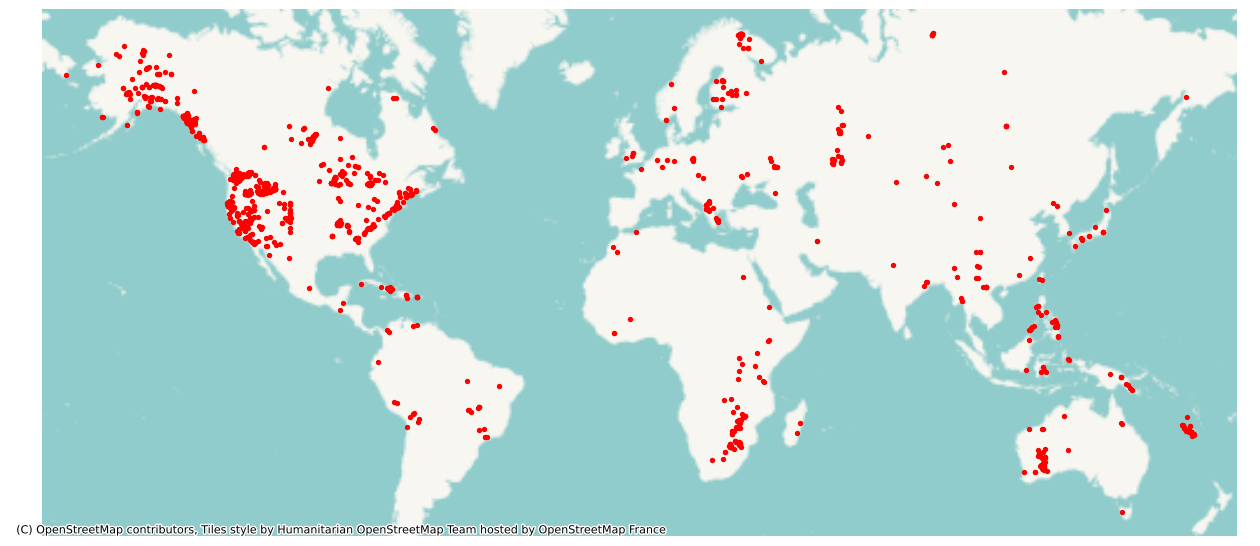

In [14]:
df_2['loc_wkt'] = df_2['loc_wkt.value'].progress_apply(safe_wkt_load)

sample_gdf = gpd.GeoDataFrame(df_2, geometry='loc_wkt', crs='epsg:4326')
# WGS84 (EPSG:4326) to Web Mercator (EPSG:3857).
sample_gdf = sample_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(16, 16))
sample_gdf.plot(ax=ax, color='red', markersize=8)
ax.set_axis_off()
ctx.add_basemap(ax)
plt.show()

## Deposit Type Classification

### Retrieve all deposit classifications

In [15]:
query = '''
SELECT ?ms ?dt_conf ?dt_s ?dt_on ?cn ?cg ?ce ?country
WHERE {
  ?ms a :MineralSite .

  ?ms :location_info [ :country ?country ] .
  
  #?ms :location_info [ :location ?loc ] .
  #FILTER(datatype(?loc) = geo:wktLiteral)
  #?ms :mineral_inventory ?mi .
  #?mi :commodity [ :name "Nickel"@en ] .
  
  ?ms :deposit_type_candidate ?dpc .
  
  ?dpc :confidence ?dt_conf .
  ?dpc :observed_name ?dt_on .
  ?dpc :source ?dt_s .
  
  OPTIONAL { ?dpc :normalized_uri [
      rdfs:label ?cn;
      :deposit_group ?cg;
      :environment ?ce ] }
}
'''
tmp_df = run_minmod_query(query, values=True)
tmp_df

,ms.value,dt_conf.value,dt_s.value,dt_on.value,cn.value,cg.value,ce.value,country.value
0,https://minmod.isi.edu/resource/mrds10111819,0.02360784076154232,"algorithm predictions, SRI deposit type classi...",Mafic-ultramafic VMS,Mafic-ultramafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal,United States
1,https://minmod.isi.edu/resource/mrds10111819,0.028219912201166153,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion chromium,U-M layered intrusion chromium,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
2,https://minmod.isi.edu/resource/mrds10111819,0.016684068366885185,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion PGE,U-M layered intrusion PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
3,https://minmod.isi.edu/resource/mrds10111819,0.02597236260771751,"algorithm predictions, SRI deposit type classi...",Ophiolite chromium,Ophiolite chromium,Ophiolite,Magmatic,United States
4,https://minmod.isi.edu/resource/mrds10111819,0.016139039769768715,"algorithm predictions, SRI deposit type classi...",Fluvial placer PGE,Fluvial placer PGE,Placer,Erosional,United States
...,...,...,...,...,...,...,...,...
15771,https://minmod.isi.edu/resource/mrds10097137,0.02494275383651257,"algorithm predictions, SRI deposit type classi...",Arc U-M intru- sion nickel- copper-PGE,Arc U-M intru- sion nickel- copper-PGE,Ultramafic and (or) mafic intrusion,Magmatic,Canada
15772,https://minmod.isi.edu/resource/site__ishkinin...,5e-01,sand,VMS,NaN,NaN,NaN,Russia
15773,https://minmod.isi.edu/resource/site__ishkinin...,5e-01,sand,Hydrothermal Ni,NaN,NaN,NaN,Russia
15774,https://minmod.isi.edu/resource/site__sudbury-...,5e-01,sand,Magmatic Sulphide,NaN,NaN,NaN,Canada


In [16]:
nickel_dc_data_df = pd.DataFrame([
    {
        'url': row['ms.value'], # navigable
        'confidence': row['dt_conf.value'],
        'source': row['dt_s.value'],
        'observed_deposit_name': row['dt_on.value'],
        'deposit_name': row['cn.value'],
        'deposit_group': row['cg.value'],
        'deposit_environment': row['ce.value'],
        'country': row['country.value']
    }
    for index, row in tmp_df.iterrows()
])
nickel_dc_data_df

,url,confidence,source,observed_deposit_name,deposit_name,deposit_group,deposit_environment,country
0,https://minmod.isi.edu/resource/mrds10111819,0.02360784076154232,"algorithm predictions, SRI deposit type classi...",Mafic-ultramafic VMS,Mafic-ultramafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal,United States
1,https://minmod.isi.edu/resource/mrds10111819,0.028219912201166153,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion chromium,U-M layered intrusion chromium,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
2,https://minmod.isi.edu/resource/mrds10111819,0.016684068366885185,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion PGE,U-M layered intrusion PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
3,https://minmod.isi.edu/resource/mrds10111819,0.02597236260771751,"algorithm predictions, SRI deposit type classi...",Ophiolite chromium,Ophiolite chromium,Ophiolite,Magmatic,United States
4,https://minmod.isi.edu/resource/mrds10111819,0.016139039769768715,"algorithm predictions, SRI deposit type classi...",Fluvial placer PGE,Fluvial placer PGE,Placer,Erosional,United States
...,...,...,...,...,...,...,...,...
15771,https://minmod.isi.edu/resource/mrds10097137,0.02494275383651257,"algorithm predictions, SRI deposit type classi...",Arc U-M intru- sion nickel- copper-PGE,Arc U-M intru- sion nickel- copper-PGE,Ultramafic and (or) mafic intrusion,Magmatic,Canada
15772,https://minmod.isi.edu/resource/site__ishkinin...,5e-01,sand,VMS,NaN,NaN,NaN,Russia
15773,https://minmod.isi.edu/resource/site__ishkinin...,5e-01,sand,Hydrothermal Ni,NaN,NaN,NaN,Russia
15774,https://minmod.isi.edu/resource/site__sudbury-...,5e-01,sand,Magmatic Sulphide,NaN,NaN,NaN,Canada


In [17]:
nickel_dc_data_df['source'].value_counts()

source
algorithm predictions, SRI deposit type classification, v0b, 20240213    14065
sand                                                                      1686
report                                                                      18
SME                                                                          7
Name: count, dtype: int64

In [18]:
nickel_dc_data_df['country'].value_counts()

country
United States    7298
Canada           2033
Australia        1336
Russia            712
South Africa      536
                 ... 
Cameroon            4
Côte d'Ivoire       4
Togo                3
Oman                3
Guinea              3
Name: count, Length: 92, dtype: int64

In [19]:
nickel_dc_data_df[nickel_dc_data_df['country'].str.contains("United")]['country'].value_counts()

country
United States               7298
United Kingdom                25
United States of America       6
Name: count, dtype: int64

In [20]:
nickel_dc_data_df[nickel_dc_data_df['country'].str.contains("United States")]

,url,confidence,source,observed_deposit_name,deposit_name,deposit_group,deposit_environment,country
0,https://minmod.isi.edu/resource/mrds10111819,0.02360784076154232,"algorithm predictions, SRI deposit type classi...",Mafic-ultramafic VMS,Mafic-ultramafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal,United States
1,https://minmod.isi.edu/resource/mrds10111819,0.028219912201166153,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion chromium,U-M layered intrusion chromium,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
2,https://minmod.isi.edu/resource/mrds10111819,0.016684068366885185,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion PGE,U-M layered intrusion PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
3,https://minmod.isi.edu/resource/mrds10111819,0.02597236260771751,"algorithm predictions, SRI deposit type classi...",Ophiolite chromium,Ophiolite chromium,Ophiolite,Magmatic,United States
4,https://minmod.isi.edu/resource/mrds10111819,0.016139039769768715,"algorithm predictions, SRI deposit type classi...",Fluvial placer PGE,Fluvial placer PGE,Placer,Erosional,United States
...,...,...,...,...,...,...,...,...
15752,https://minmod.isi.edu/resource/mrds10112530,0.017280880361795425,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion nickel- copper-PGE,U-M layered intrusion nickel- copper-PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
15753,https://minmod.isi.edu/resource/mrds10112530,0.018790079280734066,"algorithm predictions, SRI deposit type classi...",Ophiolite nickel-copper-PGE,Ophiolite nickel-copper-PGE,Ophiolite,Magmatic,United States
15754,https://minmod.isi.edu/resource/mrds10112530,0.02836831286549568,"algorithm predictions, SRI deposit type classi...",U-M conduit nickel-copper- PGE,U-M conduit nickel-copper- PGE,Ultramafic and (or) mafic conduit,Magmatic,United States
15755,https://minmod.isi.edu/resource/mrds10112530,0.01938915066421032,"algorithm predictions, SRI deposit type classi...",U-M intrusion nickel-copper- PGE,U-M intrusion nickel-copper- PGE,Ultramafic and (or) mafic intrusion,Magmatic,United States


In [21]:
# uncomment to export to csv: 
#nickel_dc_data_df.to_csv('nickel_dc_data_df.csv')

### Consolidating Desposit Type Classification data

In [22]:
'''
Komatiite nickel-copper-PGE                 Q476
U-M layered intrusion nickel- copper-PGE    Q478
U-M intrusion nickel-copper- PGE            Q481
U-M conduit nickel-copper- PGE              Q482
Ophiolite nickel-copper-PGE                 Q484
Arc U-M intru- sion nickel- copper-PGE      Q486
Anorthosite conduit nickel- copper-PGE      Q488
Impact U-M intrusion nickel- copper-PGE     Q489
'''
valid_deposit_Qs = ["Q476", "Q478", "Q481", "Q482", "Q484", "Q486", "Q488", "Q489"]
valid_deposit_Qs = ['https://minmod.isi.edu/resource/' + x for x in valid_deposit_Qs]

In [23]:
query = '''
SELECT ?ms ?oms ?dt_conf ?dt_s ?cn ?cg ?ce ?country ?dtnorm ?dtnorm_label ?loc_wkt
WHERE {
  ?ms a :MineralSite .
  
  ?ms :deposit_type_candidate ?dpc .
  
  ?dpc :confidence ?dt_conf .
  #?dpc :observed_name ?dt_on .
  ?dpc :source ?dt_s .
  OPTIONAL { ?ms owl:sameAs ?oms . }
  ?dpc :normalized_uri ?dtnorm .

  ?dtnorm rdfs:label ?dtnorm_label .
      
  #?ms :mineral_inventory ?mi .
  #?mi :commodity [ :name "Nickel"@en ] .
  
  OPTIONAL {
      ?ms :location_info [ :country ?country ] .
      ?ms :location_info [ :location ?loc_wkt ] .
      FILTER(datatype(?loc_wkt) = geo:wktLiteral)
  }
}'''  

tmp_df = run_minmod_query(query, values=True)
tmp_df

,ms.value,dt_conf.value,dt_s.value,dtnorm.value,dtnorm_label.value,country.value,loc_wkt.value,oms.value
0,https://minmod.isi.edu/resource/mrds10097173,0.017464837059378624,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q302,Residual placer lead,NaN,NaN,NaN
1,https://minmod.isi.edu/resource/mrds10097173,0.04451591894030571,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q392,Orogenic silver-lead- zinc-copper- antimony,NaN,NaN,NaN
2,https://minmod.isi.edu/resource/mrds10097173,0.016356337815523148,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q428,Vein tin polymetallic,NaN,NaN,NaN
3,https://minmod.isi.edu/resource/mrds10097173,0.01856262981891632,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q326,Supergene lead,NaN,NaN,NaN
4,https://minmod.isi.edu/resource/mrds10097173,0.020068123936653137,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q430,Vein polymetallic,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
168559,https://minmod.isi.edu/resource/httpsw3idorgus...,0.08578937500715256,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q406,Magnetite- dominant IOCG,NaN,NaN,NaN
168560,https://minmod.isi.edu/resource/httpsw3idorgus...,0.05951391905546189,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q405,Hematite- dominant IOCG,NaN,NaN,NaN
168561,https://minmod.isi.edu/resource/httpsw3idorgus...,0.0502634197473526,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q449,Skarn gold ± copper ± tungsten,NaN,NaN,NaN
168562,https://minmod.isi.edu/resource/httpsw3idorgus...,0.061068423092365265,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q404,Iron oxide gold,NaN,NaN,NaN


In [24]:
# US data
filtered_us = tmp_df[tmp_df['country.value'].isin(["USA", "United States", "United States of America"])]
filtered_nickel_us = filtered_us[filtered_us['dtnorm.value'].isin(valid_deposit_Qs)]

#### integrate reconciliation `sameAs` data (this will become redundant as we will publish `HyperMineralSite` instances)

In [25]:
'''
# todo: this will be fixed (hyper sites will be queried directly from the KG), but for now this file can be downloaded from:
https://github.com/DARPA-CRITICALMAAS/ta2-minmod-data/tree/main/sandbox/data/
'''
df_er_results = pd.read_csv('data/grouping_result.csv')
df_er_results.dropna(inplace=True)
df_er_results = df_er_results.drop_duplicates(subset=['source', 'source_id'])
query = ''' SELECT ?ms ?ms_record_id ?ms_source_id
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?ms_record_id .
                ?ms :source_id ?ms_source_id .
            } '''
df_all_sites = run_minmod_query(query, values=True)
df_all_sites.dropna(inplace=True)
df_all_sites = df_all_sites.drop_duplicates(subset=['ms_source_id.value', 'ms_record_id.value'])

In [26]:
merged_df = df_er_results.merge(df_all_sites, how='left',
                     left_on=['source', 'source_id'], 
                     right_on=['ms_source_id.value', 'ms_record_id.value'])

In [27]:
hypersite_df = filtered_nickel_us.merge(merged_df, how='left',
                     left_on='ms.value', right_on='ms.value')
hypersite_df['prediction'].fillna(value=-1, inplace=True)
hypersite_df['site_hyper_id'] = hypersite_df.progress_apply(
    lambda x: 'https://minmod.isi.edu/resource/' + str(int(x.prediction)), axis=1)
hypersite_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2507/2507 [00:00<00:00, 133700.21it/s]


,ms.value,dt_conf.value,dt_s.value,dtnorm.value,dtnorm_label.value,country.value,loc_wkt.value,oms.value,Unnamed: 0,source,source_id,prediction,ms_record_id.value,ms_source_id.value,site_hyper_id
0,https://minmod.isi.edu/resource/mrds10056259,0.03200762718915939,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,United States,POINT (-109.79635 45.35242),https://minmod.isi.edu/resource/mrds10048508,770,MRDS,10056259,1442,10056259,MRDS,https://minmod.isi.edu/resource/1442
1,https://minmod.isi.edu/resource/mrds10056259,0.020354673266410828,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,United States,POINT (-109.79635 45.35242),https://minmod.isi.edu/resource/mrds10048508,770,MRDS,10056259,1442,10056259,MRDS,https://minmod.isi.edu/resource/1442
2,https://minmod.isi.edu/resource/mrds10085467,0.019095586612820625,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q484,Ophiolite nickel-copper-PGE,United States,POINT (-66.96504 18.13817),https://minmod.isi.edu/resource/mrds10085466,1195,MRDS,10085467,293,10085467,MRDS,https://minmod.isi.edu/resource/293
3,https://minmod.isi.edu/resource/mrds10085467,0.016946667805314064,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,United States,POINT (-66.96504 18.13817),https://minmod.isi.edu/resource/mrds10085466,1195,MRDS,10085467,293,10085467,MRDS,https://minmod.isi.edu/resource/293
4,https://minmod.isi.edu/resource/mrds10112665,0.01270743366330862,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,United States,POINT (-134.802 58.02894),NaN,1467,MRDS,10112665,1734,10112665,MRDS,https://minmod.isi.edu/resource/1734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,https://minmod.isi.edu/resource/mrds10112530,0.017280880361795425,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,United States,POINT (-155.59683 62.89525),NaN,1464,MRDS,10112530,841,10112530,MRDS,https://minmod.isi.edu/resource/841
2503,https://minmod.isi.edu/resource/mrds10112530,0.018790079280734066,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q484,Ophiolite nickel-copper-PGE,United States,POINT (-155.59683 62.89525),NaN,1464,MRDS,10112530,841,10112530,MRDS,https://minmod.isi.edu/resource/841
2504,https://minmod.isi.edu/resource/mrds10112530,0.02836831286549568,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,United States,POINT (-155.59683 62.89525),NaN,1464,MRDS,10112530,841,10112530,MRDS,https://minmod.isi.edu/resource/841
2505,https://minmod.isi.edu/resource/mrds10112530,0.01938915066421032,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,United States,POINT (-155.59683 62.89525),NaN,1464,MRDS,10112530,841,10112530,MRDS,https://minmod.isi.edu/resource/841


In [28]:
hypersite_df['dt_conf.value'] = pd.to_numeric(hypersite_df['dt_conf.value'])
hypersite_df_filtered = hypersite_df[hypersite_df['dt_conf.value'] >= 0.025]

In [29]:
# unique extracted sites
hypersite_df_filtered['ms.value'].nunique()

238

In [30]:
# unique hyper (reconciled) sites
hypersite_df_filtered['site_hyper_id'].nunique()

205

In [31]:
# uncomment to export to csv: 
#hypersite_df_filtered.to_csv('hypersite_nickel_us_data_filtered.csv')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 126351.56it/s]


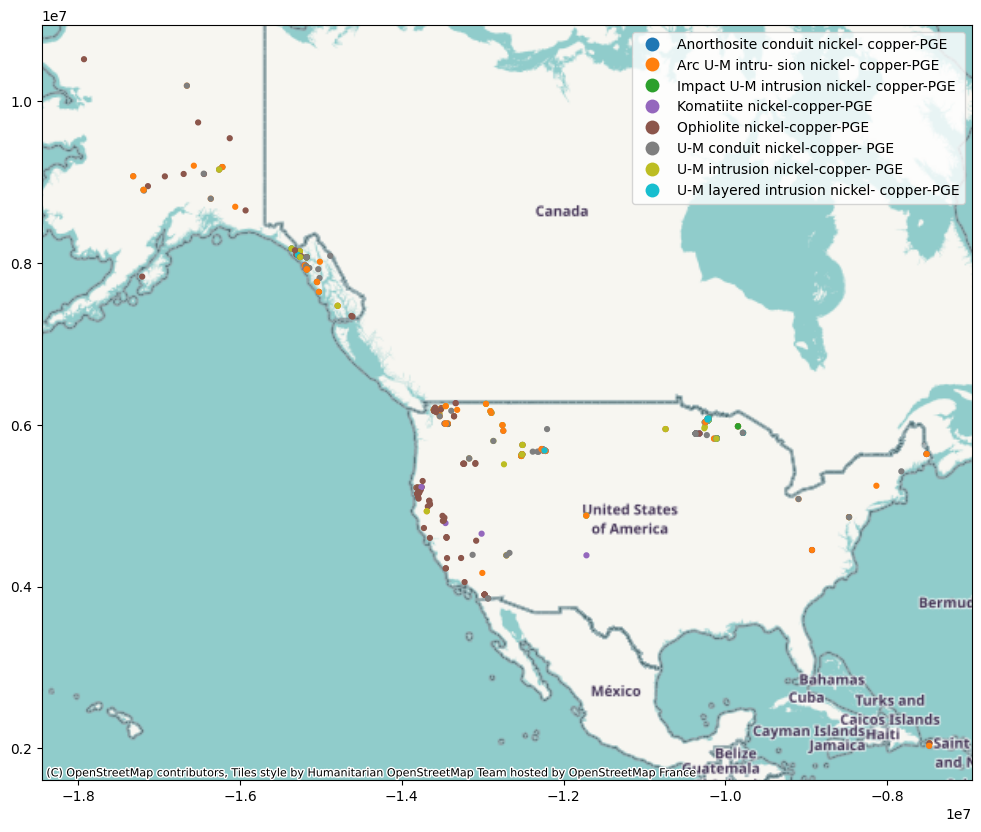

In [32]:
#visualize
hypersite_df_filtered['loc_wkt'] = hypersite_df_filtered['loc_wkt.value'].progress_apply(safe_wkt_load)
sample_gdf = gpd.GeoDataFrame(hypersite_df_filtered, geometry='loc_wkt', crs='epsg:4326')
# WGS84 (EPSG:4326) to Web Mercator (EPSG:3857).
sample_gdf = sample_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(12, 12))
sample_gdf.plot(ax=ax, markersize=12, column='dtnorm_label.value', categorical=True, legend=True)
#ax.set_axis_off()
ctx.add_basemap(ax)
plt.show()

## Grade-Tonnage models

In [33]:
query = ''' SELECT ?ms ?ms_name ?mi ?mi_cat ?ore_val ?ore_unit_lbl ?grade_val ?grade_unit_lbl ?cutoff_grade ?dt_conf ?dt_s ?dtnorm ?dtnorm_label ?country ?loc_wkt
            WHERE {
                ?ms :mineral_inventory ?mi .
                OPTIONAL { ?ms rdfs:label|:name ?ms_name . }

                ?ms :deposit_type_candidate ?dpc .
                  
                ?dpc :confidence ?dt_conf .
                ?dpc :source ?dt_s .
                ?dpc :normalized_uri ?dtnorm .
                ?dtnorm rdfs:label ?dtnorm_label .
                
                OPTIONAL {
                      ?ms :location_info [ :country ?country ] .
                      #?ms :location_info [ :location ?loc_wkt ] .
                      #FILTER(datatype(?loc_wkt) = geo:wktLiteral)
                }
                
                ?mi :category ?mi_cat .
                ?mi :commodity [ :name "Nickel"@en ] .
                
                OPTIONAL { ?mi :ore [ :ore_value ?ore_val;
                                      :ore_unit  ?ore_unit] .
                                      ?ore_unit rdfs:label ?ore_unit_lbl . }
                OPTIONAL { ?mi :grade [ :grade_value ?grade_val;
                                      :grade_unit  ?grade_unit] .
                                      ?grade_unit rdfs:label ?grade_unit_lbl . }
                OPTIONAL { ?mi :cutoff_grade [ :grade_value ?cutoff_grade ] . }
            } '''
query_resp_df = run_minmod_query(query, values=True)
query_resp_df

,ms.value,ms_name.value,mi.value,mi_cat.value,dt_conf.value,dt_s.value,dtnorm.value,dtnorm_label.value,country.value,ore_val.value,ore_unit_lbl.value,grade_val.value,grade_unit_lbl.value,cutoff_grade.value
0,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,https://minmod.isi.edu/resource/mrds10293637-h...,https://minmod.isi.edu/resource/inferred,0.03606511279940605,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q366,Sedimentary manganese,United States,NaN,NaN,NaN,NaN,NaN
1,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,https://minmod.isi.edu/resource/mrds10293637-h...,https://minmod.isi.edu/resource/inferred,0.028172817081212997,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q444,Replacement fluorite,United States,NaN,NaN,NaN,NaN,NaN
2,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,https://minmod.isi.edu/resource/mrds10293637-h...,https://minmod.isi.edu/resource/inferred,0.04032892361283302,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q361,Phosphorite,United States,NaN,NaN,NaN,NaN,NaN
3,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,https://minmod.isi.edu/resource/mrds10293637-h...,https://minmod.isi.edu/resource/inferred,0.02401875331997871,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q429,Vein fluorite,United States,NaN,NaN,NaN,NaN,NaN
4,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,https://minmod.isi.edu/resource/mrds10293637-h...,https://minmod.isi.edu/resource/inferred,0.0372144877910614,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q453,Skarn uranium- REE,United States,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20560,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,https://minmod.isi.edu/resource/httpsw3idorgus...,https://minmod.isi.edu/resource/indicated,0.08792237192392349,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,United States,3639000,tonnes,1.83,percent,0.83
20561,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,https://minmod.isi.edu/resource/httpsw3idorgus...,https://minmod.isi.edu/resource/indicated,1e+00,expert,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,United States,3639000,tonnes,1.83,percent,0.83
20562,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,https://minmod.isi.edu/resource/httpsw3idorgus...,https://minmod.isi.edu/resource/indicated,1,SME,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,United States,3639000,tonnes,1.83,percent,0.83
20563,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,https://minmod.isi.edu/resource/httpsw3idorgus...,https://minmod.isi.edu/resource/indicated,0.08093538135290146,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,United States,3639000,tonnes,1.83,percent,0.83


In [34]:
mineral_data_df = pd.DataFrame([
    {
        'ms': row['ms.value'], # This is not yet the name, it's the suffix of the uri
        'ms_name': row['ms_name.value'] if len(row['ms_name.value']) > 0 else row['ms.value'].split('/')[-1],
        'mi': row['mi.value'].split('/')[-1],
        'mi_cat': row['mi_cat.value'].lower().split('/')[-1],
        'ore_val': float(row['ore_val.value']),
        'ore_unit': row['ore_unit_lbl.value'],
        'grade_val': float(row['grade_val.value']),
        'grade_unit': row['grade_unit_lbl.value'],
        'cutoff_grade': float(row['cutoff_grade.value']),
        'cutoff_grade_unit': row['cutoff_grade.value'],
        'deposit_type_qnode': row['dtnorm.value'],
        'deposit_type': row['dtnorm_label.value'],
        'dep_type_score': float(row['dt_conf.value']),
        'country': row['country.value']
        #'loc_wkt': row['loc_wkt.value']
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,ms,ms_name,mi,mi_cat,ore_val,ore_unit,grade_val,grade_unit,cutoff_grade,cutoff_grade_unit,deposit_type_qnode,deposit_type,dep_type_score,country
0,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,mrds10293637-httpsmrdatausgsgovmrdsrecord10293...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q366,Sedimentary manganese,0.036065,United States
1,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,mrds10293637-httpsmrdatausgsgovmrdsrecord10293...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q444,Replacement fluorite,0.028173,United States
2,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,mrds10293637-httpsmrdatausgsgovmrdsrecord10293...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q361,Phosphorite,0.040329,United States
3,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,mrds10293637-httpsmrdatausgsgovmrdsrecord10293...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q429,Vein fluorite,0.024019,United States
4,https://minmod.isi.edu/resource/mrds10293637,Cedar Creek Syncline,mrds10293637-httpsmrdatausgsgovmrdsrecord10293...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q453,Skarn uranium- REE,0.037214,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20560,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,httpsw3idorgusgsz45306929g3s5x951-httpsw3idorg...,indicated,3639000.0,tonnes,1.83,percent,0.83,0.83,https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,0.087922,United States
20561,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,httpsw3idorgusgsz45306929g3s5x951-httpsw3idorg...,indicated,3639000.0,tonnes,1.83,percent,0.83,0.83,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,1.000000,United States
20562,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,httpsw3idorgusgsz45306929g3s5x951-httpsw3idorg...,indicated,3639000.0,tonnes,1.83,percent,0.83,0.83,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,1.000000,United States
20563,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,httpsw3idorgusgsz45306929g3s5x951-httpsw3idorg...,indicated,3639000.0,tonnes,1.83,percent,0.83,0.83,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,0.080935,United States


In [35]:
filtered_us = mineral_data_df[mineral_data_df['country'].isin(["USA", "United States", "United States of America"])]
filtered_nickel_us = filtered_us[filtered_us['deposit_type_qnode'].isin(valid_deposit_Qs)]
mineral_data_df = filtered_nickel_us.copy()
mineral_data_df

,ms,ms_name,mi,mi_cat,ore_val,ore_unit,grade_val,grade_unit,cutoff_grade,cutoff_grade_unit,deposit_type_qnode,deposit_type,dep_type_score,country
41,https://minmod.isi.edu/resource/mrds10112856,Blue Lake,mrds10112856-httpsmrdatausgsgovmrdsrecord10112...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,0.013912,United States
50,https://minmod.isi.edu/resource/mrds10185467,Linda Nickel,mrds10185467-httpsmrdatausgsgovmrdsrecord10185...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q489,Impact U-M intrusion nickel- copper-PGE,0.025867,United States
51,https://minmod.isi.edu/resource/mrds10185467,Linda Nickel,mrds10185467-httpsmrdatausgsgovmrdsrecord10185...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,0.030184,United States
52,https://minmod.isi.edu/resource/mrds10185467,Linda Nickel,mrds10185467-httpsmrdatausgsgovmrdsrecord10185...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,0.028536,United States
53,https://minmod.isi.edu/resource/mrds10185467,Linda Nickel,mrds10185467-httpsmrdatausgsgovmrdsrecord10185...,inferred,NaN,NaN,NaN,NaN,NaN,NaN,https://minmod.isi.edu/resource/Q484,Ophiolite nickel-copper-PGE,0.027746,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20560,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,httpsw3idorgusgsz45306929g3s5x951-httpsw3idorg...,indicated,3639000.0,tonnes,1.83,percent,0.83,0.83,https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,0.087922,United States
20561,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,httpsw3idorgusgsz45306929g3s5x951-httpsw3idorg...,indicated,3639000.0,tonnes,1.83,percent,0.83,0.83,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,1.000000,United States
20562,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,httpsw3idorgusgsz45306929g3s5x951-httpsw3idorg...,indicated,3639000.0,tonnes,1.83,percent,0.83,0.83,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,1.000000,United States
20563,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,httpsw3idorgusgsz45306929g3s5x951-httpsw3idorg...,indicated,3639000.0,tonnes,1.83,percent,0.83,0.83,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,0.080935,United States


In [36]:
# keep only highest confidence per mineral site uri
# group by 'ms' & find the index of the highest 'dep_type_score' in each group
idx = mineral_data_df.groupby('ms')['dep_type_score'].idxmax()
#  keep only the rows with the highest 'dep_type_score' for each 'ms'
filtered_mineral_data_df = mineral_data_df.loc[idx]
mineral_data_df = filtered_mineral_data_df
mineral_data_df

,ms,ms_name,mi,mi_cat,ore_val,ore_unit,grade_val,grade_unit,cutoff_grade,cutoff_grade_unit,deposit_type_qnode,deposit_type,dep_type_score,country
6345,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report on the Maturi Birch...,httpsw3idorgusgsz45306925b32tx471-httpsw3idorg...,indicated,538.000,million tonnes,0.19,percent,0.40,0.4,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,1.000000,USA
19790,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,httpsw3idorgusgsz45306929g3s5x951-httpsw3idorg...,inferred,570000.000,tonnes,5.86,percent,0.83,0.83,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,1.000000,United States
10466,https://minmod.isi.edu/resource/httpsw3idorgus...,Technical Report on the Mineral Resource Estim...,httpsw3idorgusgsz4530692cgwu8xbq1-httpsw3idorg...,inferred,106.000,million tonnes,0.28,percent,24.00,24,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,1.000000,United States of America
1503,https://minmod.isi.edu/resource/httpsw3idorgus...,Preliminary Economic Assessment (PEA) #3 of th...,httpsw3idorgusgsz4530692dss9vbek1-httpsw3idorg...,indicated,1462000.000,tonnes,5.72,percent,0.50,0.5,https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,0.100286,United States
3242,https://minmod.isi.edu/resource/httpsw3idorgus...,Preliminary Economic Assessment (PEA) of the T...,httpsw3idorgusgsz4530692hcuf4gst1-httpsw3idorg...,inferred,2705000.000,tonnes,0.90,percent,0.83,0.83,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,1.000000,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8129,https://minmod.isi.edu/resource/site__snipe-ba...,Snipe Bay,invn__Q578__inferred__site_9ecc6__doc_cca88,inferred,0.390,million tonnes,0.30,percent,NaN,NaN,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,1.000000,USA
60,https://minmod.isi.edu/resource/site__spruce-r...,Spruce Road,invn__Q578__inferred__site_03726__doc_dbcde,inferred,435.500,million tonnes,0.16,percent,NaN,NaN,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,1.000000,USA
1134,https://minmod.isi.edu/resource/site__stillwat...,Stillwater-East Boulder,invn__Q578__measured__site_2f01b__doc_de91a,measured,9.000,million tonnes,0.10,percent,NaN,NaN,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,1.000000,USA
4455,https://minmod.isi.edu/resource/site__tamarack...,Tamarack North,invn__Q578__inferred__site_d54a8__doc_4ac42,inferred,4.382,million tonnes,1.58,percent,NaN,NaN,https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,1.000000,USA


In [37]:
filtered_mineral_data_df = mineral_data_df[mineral_data_df['mi_cat'].isin(['inferred', 'indicated', 'measured'])]

In [38]:
# todo: assumes "million tonnes" OR "tonnes" for ore_unit & percent for grade_unit (the case as of today)
# normalize: convert rows with tonnes to million tonnes 
filtered_mineral_data_df['norm_ore_val'] = filtered_mineral_data_df.apply(lambda row:
                             row['ore_val'] * 1e6 if row['ore_unit'] == 'million tonnes' else row['ore_val'], axis=1)

In [39]:
# pivot the table: new df with each 'mi_cat' as a prefix
pivot_df = filtered_mineral_data_df.pivot_table(index=['ms', 'ms_name', 'deposit_type', 'dep_type_score'], columns='mi_cat', 
                          values=['norm_ore_val', 'grade_val', 'cutoff_grade'],
                          aggfunc='first')
# flatten the MultiIndex in columns
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
# reset index to turn 'ms' back into a column
pivot_df.reset_index(inplace=True)
pivot_df.fillna('', inplace=True)
pivot_df

,ms,ms_name,deposit_type,dep_type_score,cutoff_grade_indicated,cutoff_grade_inferred,grade_val_indicated,grade_val_inferred,grade_val_measured,norm_ore_val_indicated,norm_ore_val_inferred,norm_ore_val_measured
0,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report on the Maturi Birch...,U-M layered intrusion nickel- copper-PGE,1.000000,0.4,,0.19,,,538000000.0,,
1,https://minmod.isi.edu/resource/httpsw3idorgus...,Updated Preliminary Economic Assessment on the...,U-M conduit nickel-copper- PGE,1.000000,,0.83,,5.86,,,570000.0,
2,https://minmod.isi.edu/resource/httpsw3idorgus...,Technical Report on the Mineral Resource Estim...,U-M layered intrusion nickel- copper-PGE,1.000000,,24.0,,0.28,,,106000000.0,
3,https://minmod.isi.edu/resource/httpsw3idorgus...,Preliminary Economic Assessment (PEA) #3 of th...,U-M intrusion nickel-copper- PGE,0.100286,0.5,,5.72,,,1462000.0,,
4,https://minmod.isi.edu/resource/httpsw3idorgus...,Preliminary Economic Assessment (PEA) of the T...,U-M conduit nickel-copper- PGE,1.000000,,0.83,,0.9,,,2705000.0,
...,...,...,...,...,...,...,...,...,...,...,...,...
24,https://minmod.isi.edu/resource/site__snipe-ba...,Snipe Bay,U-M layered intrusion nickel- copper-PGE,1.000000,,,,0.3,,,390000.0,
25,https://minmod.isi.edu/resource/site__spruce-r...,Spruce Road,U-M layered intrusion nickel- copper-PGE,1.000000,,,,0.16,,,435500000.0,
26,https://minmod.isi.edu/resource/site__stillwat...,Stillwater-East Boulder,U-M layered intrusion nickel- copper-PGE,1.000000,,,,,0.1,,,9000000.0
27,https://minmod.isi.edu/resource/site__tamarack...,Tamarack North,U-M conduit nickel-copper- PGE,1.000000,,,,1.58,,,4382000.0,


In [40]:
def get_total_grade_tonnage(flat_mi):
    ''' assumes tonnage units in tonnes 
        input: flat_mi = flat mineral inventory record (pandas seriers record)
        output: total_tonnage, total_grade '''
    
    # init in case of None(s)
    contained_measured, contained_indicated, contained_inferred = 0, 0, 0
    
    tonnage_measured  = float(flat_mi.norm_ore_val_measured)  if flat_mi.norm_ore_val_measured  != '' else 0
    tonnage_indicated = float(flat_mi.norm_ore_val_indicated) if flat_mi.norm_ore_val_indicated != '' else 0
    tonnage_inferred  = float(flat_mi.norm_ore_val_inferred)  if flat_mi.norm_ore_val_inferred  != '' else 0

    total_tonnage = tonnage_measured + tonnage_indicated + tonnage_inferred

    if total_tonnage == 0:
        return None, None

    '''
    (1) contained_nickel_of_measured  = measured_tonnage  * grade (commodity)
    (2) contained_nickel_of_indicated = indicated_tonnage * grade (commodity)
    (3) contained_nickel_of_inferred  = inferred_tonnage  * grade (commodity)
    (4) total_tonnage [X axis]        = measured_tonnage + indicated_tonnage + inferred_tonnage
    (5) total_contained_metal         = contained_nickel_of_measured + contained_nickel_of_indicated + contained_nickel_of_inferred 
    (6) total_grade   [Y axis]        = (5)/(4) 
    '''
    
    if flat_mi.grade_val_measured != '':
        contained_measured  = tonnage_measured  * float(flat_mi.grade_val_measured)
    if flat_mi.grade_val_indicated != '':
        contained_indicated = tonnage_indicated * float(flat_mi.grade_val_indicated)
    if flat_mi.grade_val_inferred != '':
        contained_inferred  = tonnage_inferred  * float(flat_mi.grade_val_inferred)
    
    total_contained_metal = contained_measured + contained_indicated + contained_inferred

    if total_contained_metal == 0:
        return None, None

    total_grade = float(total_contained_metal) / float(total_tonnage)

    return total_tonnage, total_grade

In [41]:
# apply the function and get the results as a list of tuples
gr_ton_results = pivot_df.progress_apply(lambda x: get_total_grade_tonnage(x), axis=1)
# split the results into two separate Series and assign them to new columns
pivot_df['total_tonnage'], pivot_df['total_grade'] = zip(*gr_ton_results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 20788.72it/s]


In [42]:
# uncomment to export to csv: 
#pivot_df.to_csv('flat_mineral_site_data.v3.csv', index=False)

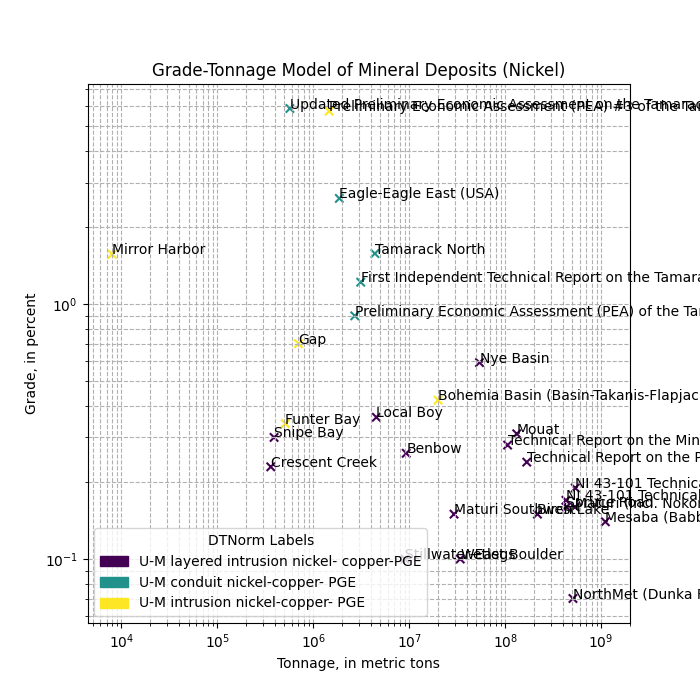

In [44]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import webbrowser

# Your existing DataFrame and data extraction
tonnages = pivot_df['total_tonnage'].values
grades = pivot_df['total_grade'].values
names = pivot_df['ms_name'].values
dtnorm_labels = pivot_df['deposit_type'].values
urls = pivot_df['ms'].values  # URLs corresponding to each point

# Define color for each unique category in 'dtnorm_label_value'
unique_labels = pivot_df['deposit_type'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Using 'viridis' colormap
color_map = dict(zip(unique_labels, colors))

# Create list of colors for each point
point_colors = [color_map[label] for label in dtnorm_labels]

plt.figure(figsize=(7, 7))
scatter = plt.scatter(tonnages, grades, marker='x', c=point_colors, picker=5)  # Enable picking with a tolerance of 5 points

# Logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Tonnage, in metric tons')
plt.ylabel('Grade, in percent')
plt.title('Grade-Tonnage Model of Mineral Deposits (Nickel)')

plt.grid(True, which="both", ls="--")

# Annotations
for i, txt in enumerate(names):
    plt.annotate(txt, (tonnages[i], grades[i]))

# Legend
legend_handles = [mpatches.Patch(color=color_map[label], label=label) for label in unique_labels]
plt.legend(handles=legend_handles, title="DTNorm Labels", loc='lower left')

# Function to open URL on click
def on_pick(event):
    ind = event.ind[0]  # Index of the picked scatter point
    url = urls[ind]
    webbrowser.open(url)  # Open the URL

# Connect the pick event to the on_pick function
plt.gcf().canvas.mpl_connect('pick_event', on_pick)

plt.show()